In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly; for `python_path` on molgpu, you can either
1) set up your own ms-gen environment from source
2) use Mrunali's pre-built environment, after telling conda to look in her folder with `conda config --add envs_dirs /home/mrunali/miniconda3/envs`
3) Clone Mrunali's pre-built environment into your own environment with `conda --clone` and then source that instead.

In [3]:
config = load_global_config()

The following cell enables SA score. See instructions in [the rdkik blog](https://greglandrum.github.io/rdkit-blog/posts/2023-12-01-using_sascore_and_npscore.html)
You can safely skip it if you are not setting ``sa_score=True`` in function ``plot_top_mols``

In [4]:
# sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
sys.path.append(os.path.join('/home/roger/miniforge3/envs/ms-main','share','RDKit','Contrib'))
from SA_Score import sascorer

## Round 1

In [5]:
def elucidation(spec_file, formula, adduct, energy, real_smi=None, name="", vis_peaks=False, candidates='pubchem', buyable_report=False, **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = False # use nce for collision energy
    _config['merge_spec'] = True # merge spec fro visualization
    _config['adduct'] = adduct
    for k, v in kwargs.items():
        _config[k] = v
    exp_spec_path = f'/home/roger/ms_collaborators/David/{spec_file}.ms'

    # Get candidates
    if candidates == 'pubchem':
        smiles = candidates_from_pubchem(formula)
    else:
        smiles = candidates

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, energy, **_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, mol_name=name, real_smiles=real_smi, topk=10, **_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if vis_peaks:
        explain_peaks(result_path, exp_spec_path, pmz, real_smi, num_peaks=10, save_path=f'{spec_file}.pdf', **_config)

    # Buyable report
    if buyable_report:
        generate_buyable_report(
            [spec_file], # names
            [exp_spec_path], #exp_specs
            [{adduct: smiles}], # adduct_to_smiles
            _config,
            energy, topk_per_row=10, output_name=f'david_{spec_file}_buyable_report')

    return img

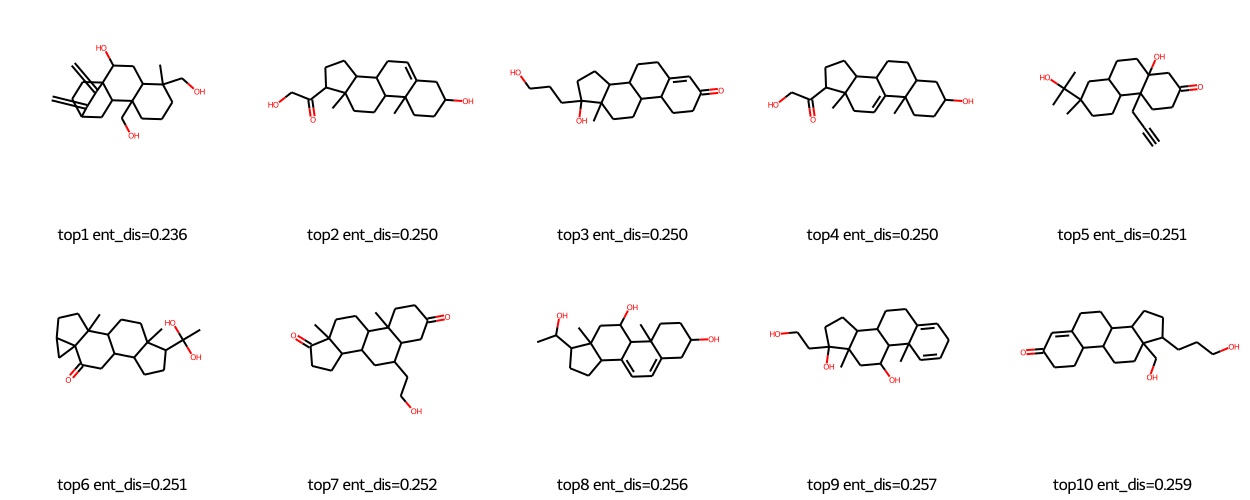

In [18]:
elucidation('DC_MX_1', 'C21H32O3', '[M-H2O+H]+', [30], buyable_report=False)

In [6]:
DC1_candidates = [
    'CC(=O)OCC1OC(OC2=C(OC)C=C(CC3N=CC(=O)C(OC)=C3)C=C2)C(OC(=O)C)C(OCCC)C1OC(=O)CCCC(=O)NC4=CC=CC(=O)C4',
    'CCCC1CC(=O)C(OC)=C(N)C1CC2=CC(OC)=C(OC3OC(COC(=O)C)C(OC(=O)C)C(OC(=O)C#CC#CC)C3OC(=O)CC)C(=O)C=C2N',
    'C(=O)OC1OC(OC2=CC=C(CN(C(=O)C)C3=CC(OC)=C(OC)C=C3)C=C2OC)C(OC(=O)C)C(OC(=O)CC)C1OC(=O)CCNC4=CCCC=C4',
    'C=C=CNC1=C(OC)C=C(C=C2NC(=O)C(OC3OC(COC(=O)C)C(OC(=O)C)C(OC(=O)CC)C3OC(=O)CC)=CC=C2)C(=O)C=C1OCCCC',
    'C=C=CNC1=C(OC)C=C(C=C2NC(=O)C(OC3OC(COC(=O)C)C(OC(=O)C)C(OC(=O)CC)C3OC(=O)CC)=CC=C2)C(=O)C=C1OC(CCC)',
    'CC(=O)C(C=C)CC(=O)OC1C(OC(=O)C)CC(OC2=CC=CC(=O)N2COC(=O)CCCC(=O)OCCC)C=CCC1(C)OC1=CC=CC(=O)N1C=O',
    'CC(O)OC1CC2(OC(=O)C(C)CC)C(OC(C)=O)CC1(OC1=CC=CC(=O)N1C)C2OC(=O)C(C1CC(=O)NC1)c1cc(C(=O)O)c(C(=O)C)cc1C',
    'COC(CC)C(=O)OC1(CC2CC=CC(=O)N2C)CC(OC(=O)C)C(OC(=O)C)CC1OC1=CC=CC(=O)C(C(=O)C)c2cc(C(=O)O)ccc2NC1O',
    'CC(=O)OC=C1OC(CC2=CC=CC(=O)N2C)C(OC(=O)C(C)CC)C(OC(C)=O)C1OC1CC=CC(=O)N1C(C(=O)C)C(C(=O)C)C=COC=C=CO',
    'O=C([C@@H](CC)C)OC[C@]1([C@@H](OC(C)=O)[C@H](C[C@@H](C)[C@]1([C@H]2OC(C)=O)OC([C@@H]2[C@H]3OC(C4=CN(C)C(C=C4)=O)=O)(C)C)OC(C5=CN(C)C(C=C5)=O)=O)C3=O',
    'CC[C@@H](C)C(=O)C(O)[C@H](C)CC(=O)CC[C@@H](C)C(=O)Oc1ccc(=O)C(O)c1CC(O)OC(=O)c1ccc(=O)n(C)c1CC(=O)Oc1ccc(=O)n(C)c1',
    'O=CC1=CC=CCN1C1(C)C=CCC(OC(=O)CC)CC(OC(=O)C)C1C(=O)OCC(=O)COC2=CC=CC(=O)N2COCCCC(=O)OC(C=C)C=O',
]
DC1_candidates = [common.rm_stereo(smi) for smi in DC1_candidates]

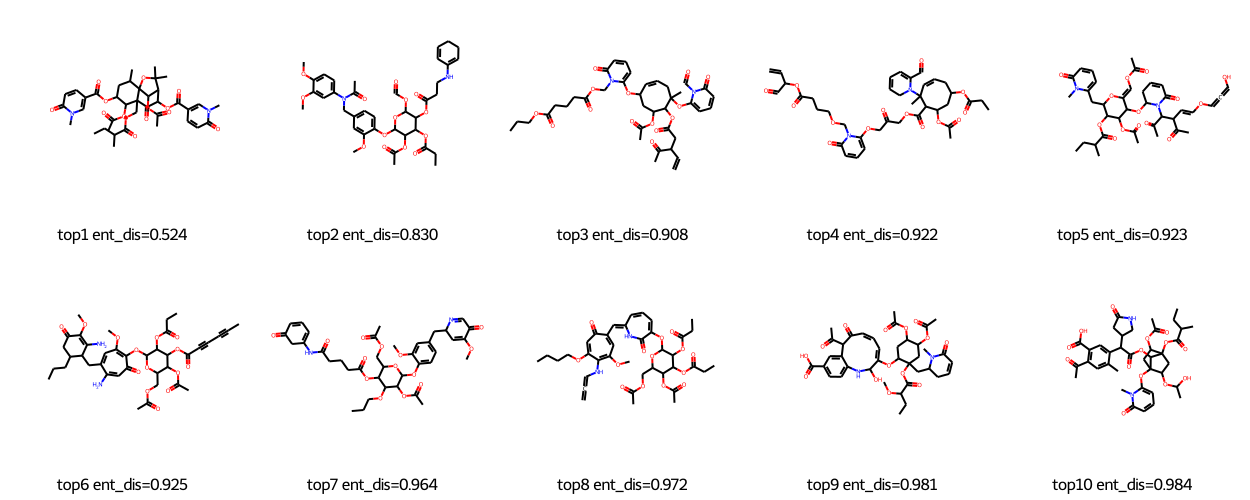

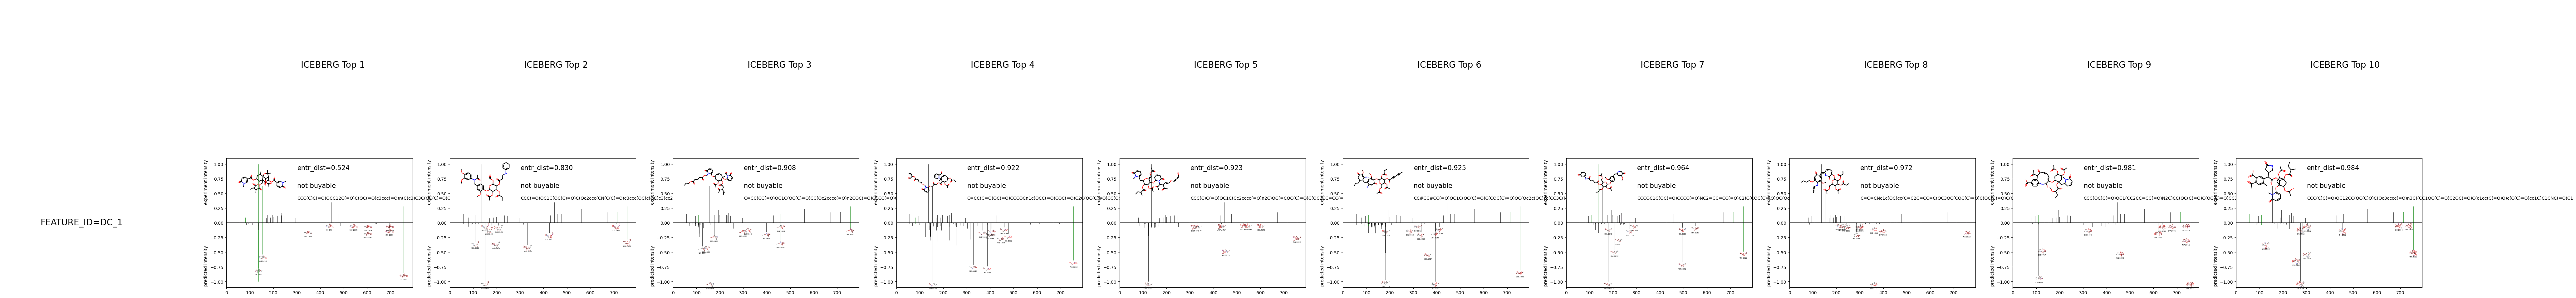

In [19]:
elucidation('DC_1', 'C38H47N2O14', '[M+H]+', [15, 30, 45], candidates=DC1_candidates, buyable_report=True, step_collision_energy=True)

In [22]:
common.form_from_smi(DC1_candidates[0])

'C38H46N2O14'